In [1]:
#!mv "./Assignment 5 Dataset" "./drive/My Drive/"
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! unzip './drive/My Drive/Assignment 05.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: Assignment 5 Dataset/train/normal/7f11cf49-7b97-4d39-82a1-18411a4599cd.png  
  inflating: Assignment 5 Dataset/train/normal/7f12966e-c382-4f9e-90ac-e1575dcdc812.png  
  inflating: Assignment 5 Dataset/train/normal/7f

In [0]:
import cv2
import glob
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch import cuda
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
data_dir = 'Assignment 5 Dataset'
batch_size = 120

In [5]:
#Define transforms for the training data and testing data
# mean [0.517, 0.517, 0.517]   std [0.219, 0.219, 0.219]
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.517, 0.517, 0.517],
                                                            [0.21, 0.21, 0.21])])

valid_transforms = transforms.Compose([transforms.Resize(224),                             
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.517, 0.517, 0.517],
                                                            [0.21, 0.21, 0.21])])

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.517, 0.517, 0.517],
                                                            [0.21, 0.21, 0.21])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform = train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/validation', transform = valid_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform = test_transforms)


#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


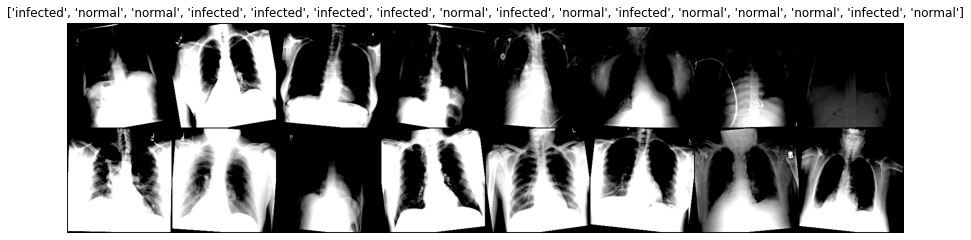

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(15,15))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs[:16])
    imshow(out, title=[class_names[x] for x in classes[:16]])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [0]:
def get_model(name, pretrain):
    if name == 'vgg16':
        model = models.vgg16(pretrained=pretrain)
        
        num_features = model.classifier[6].in_features
        features = list(model.classifier.children())[:-1]
        num_features = model.classifier[5]
        features = list(model.classifier.children())[:-2]
        num_features = model.classifier[4]
        features = list(model.classifier.children())[:-3]
        num_features = model.classifier[3].in_features
        features = list(model.classifier.children())[:-4]
        num_features = model.classifier[2]
        features = list(model.classifier.children())[:-5] 
        num_features = model.classifier[1]
        features = list(model.classifier.children())[:-6] 
        num_features = model.classifier[0]
        features = list(model.classifier.children())[:-7]

        for param in model.features[:26].parameters():
            param.requires_grad = False 

        n_inputs = 25088
        model.classifier = nn.Sequential(
            nn.Linear(n_inputs, 180), nn.ReLU(), nn.Dropout(0.55),
            nn.Linear(180, len(class_names)), nn.Softmax(dim=1))

    elif name == 'resnet18':
        model = models.resnet18(pretrained=pretrain)
        
        features_num = model.fc
        resnet_feature = list(model.fc.children())[:0]

        for param in model.layer1.parameters():
            param.requires_grad = False
        for param in model.layer2.parameters():
            param.requires_grad = False
        for param in model.layer3.parameters():
            param.requires_grad = False
        
        n_inputs = 512
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 180), nn.ReLU(), nn.Dropout(0.50),
            nn.Linear(180, len(class_names)), nn.Softmax(dim=1))

    # get gpu
    if gpu: model = model.to('cuda')
    else: model = model.to('cpu')
    
    return model

In [0]:
def plotCurves(stats):
    plt.figure(figsize=(8, 6))
    for c in ['train_loss', 'valid_loss']:
        plt.plot(stats[c], label=c)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Training and Validation Loss Curve')

    plt.figure(figsize=(8, 6))
    for c in ['train_acc', 'valid_acc']:
        plt.plot(100 * stats[c], label=c)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curve')
    plt.show()

In [9]:
# Check if gpu is available
gpu = cuda.is_available()
print('Gpu is available:',gpu)

Gpu is available: True


In [29]:
model = get_model('resnet18', True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [30]:
from torchsummary import summary
summary(model, (3, 224, 224), batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [120, 64, 112, 112]           9,408
       BatchNorm2d-2        [120, 64, 112, 112]             128
              ReLU-3        [120, 64, 112, 112]               0
         MaxPool2d-4          [120, 64, 56, 56]               0
            Conv2d-5          [120, 64, 56, 56]          36,864
       BatchNorm2d-6          [120, 64, 56, 56]             128
              ReLU-7          [120, 64, 56, 56]               0
            Conv2d-8          [120, 64, 56, 56]          36,864
       BatchNorm2d-9          [120, 64, 56, 56]             128
             ReLU-10          [120, 64, 56, 56]               0
       BasicBlock-11          [120, 64, 56, 56]               0
           Conv2d-12          [120, 64, 56, 56]          36,864
      BatchNorm2d-13          [120, 64, 56, 56]             128
             ReLU-14          [120, 64,

In [0]:
# hyper-parameters initialization
Epochs = 31
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

Training Started.......
Epoch  0 : 	Training Loss: 0.5650, Training Accuracy: 76.275% 	Validation Loss: 0.5074, Validation Accuracy: 82.733%
Epoch  1 : 	Training Loss: 0.4676, Training Accuracy: 85.975% 	Validation Loss: 0.4778, Validation Accuracy: 83.933%
Epoch  2 : 	Training Loss: 0.4479, Training Accuracy: 87.042% 	Validation Loss: 0.4669, Validation Accuracy: 84.933%
Epoch  3 : 	Training Loss: 0.4355, Training Accuracy: 88.358% 	Validation Loss: 0.4594, Validation Accuracy: 85.467%
Epoch  4 : 	Training Loss: 0.4265, Training Accuracy: 89.017% 	Validation Loss: 0.4543, Validation Accuracy: 85.600%
Epoch  5 : 	Training Loss: 0.4223, Training Accuracy: 89.333% 	Validation Loss: 0.4467, Validation Accuracy: 86.333%
Epoch  6 : 	Training Loss: 0.4170, Training Accuracy: 89.917% 	Validation Loss: 0.4465, Validation Accuracy: 86.067%
Epoch  7 : 	Training Loss: 0.4139, Training Accuracy: 90.292% 	Validation Loss: 0.4448, Validation Accuracy: 86.267%
Epoch  8 : 	Training Loss: 0.4109, Train

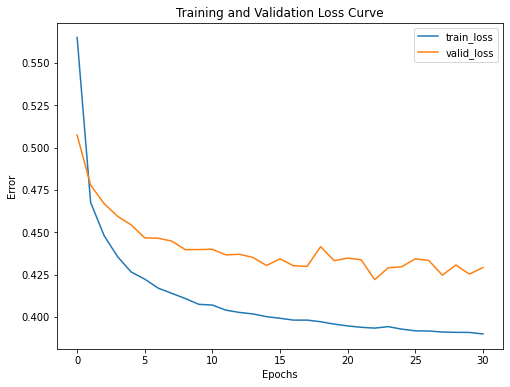

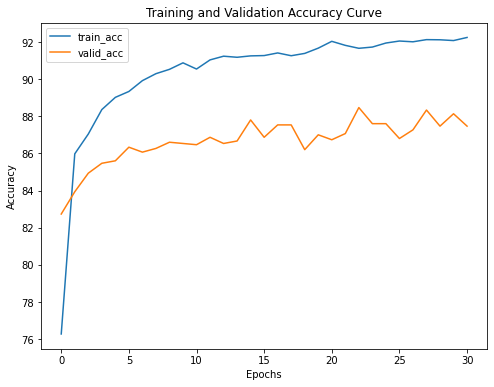

In [0]:
device = torch.device("cuda")

model.to(device)
model.train()

stats = []
print('Training Started.......')
for epoch in range(Epochs): 

    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0

    # Training dataset pass
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)               
        loss = criterion(outputs, labels)   
        loss.backward()                    
        optimizer.step()                 

        # print statistics
        train_loss += loss.item() * inputs.size(0)

        # Calculate train accuracy
        _, pred = torch.max(outputs, dim=1)
        correct_tensor = pred.eq(labels.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        train_acc += accuracy.item() * inputs.size(0)

    train_loss = train_loss / len(trainloader.dataset)
    train_acc = train_acc / len(trainloader.dataset)

    # We don't need to save grads because no backprop is required for validation set
    with torch.no_grad():
        model.eval()
        # Validation dataset pass
        for i, data in enumerate(validloader):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Validation loss
            outputs = model(inputs) 
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            _, pred = torch.max(outputs, dim=1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            valid_acc += accuracy.item() * inputs.size(0)

        valid_loss = valid_loss / len(validloader.dataset)
        valid_acc = valid_acc / len(validloader.dataset)

        model.optimizer = optimizer
        stats.append([train_loss, valid_loss, train_acc, valid_acc])
    print('Epoch',epoch,':',f' Training Loss: {train_loss:.4f},',f'Training Accuracy: {100 * train_acc:.3f}%', f' Validation Loss: {valid_loss:.4f},',f'Validation Accuracy: {100 * valid_acc:.3f}%')
    stat = pd.DataFrame(stats, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
    torch.save(model, './drive/My Drive/vgg16_half.pth')

print('Finished Training')
plotCurves(stat)

In [0]:
plotCurves(stat)

Test data predictions

In [0]:
# Load the trained model
checkpoint = torch.load('./drive/My Drive/resnet18_entire.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

Accuracy of the network on the test images: 93 %
F1: 0.9500000000000001
Precision: 0.9151832460732985
Recall: 0.9875706214689266


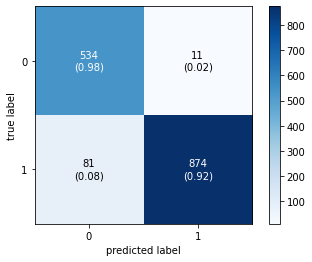

In [42]:
# Metric evaluation on Test dataset
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from mlxtend.plotting import plot_confusion_matrix
correct = 0
total = 0
device = torch.device("cuda")
model = model.to('cuda')
pred = []
orig = []
with torch.no_grad():
    model.eval()
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred.extend(predicted)
        orig.extend(labels)
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
print('F1: {}'.format(f1_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
print('Precision: {}'.format(precision_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
print('Recall: {}'.format(recall_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
# 0 is for infected 1 is for normal
cm = confusion_matrix(torch.FloatTensor(pred), torch.FloatTensor(orig))
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()


Plot well classified and worst classified images

In [0]:
def show_img(image, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    # undoing the preprocessing we did on test image 
    mean = 0.517
    std = 0.219
    image = std * image + mean
    image = np.clip(image, 0, 1)
    image = image.transpose((1, 2, 0))
    ax.imshow(image)
    plt.axis('off')

In [44]:
device = torch.device("cpu")
model = model.to('cpu')

class1_image, target1, losses1, class0_image, target0, losses0 = [],[],[],[],[],[]
with torch.no_grad():
    model.eval()
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        if labels == 1:
          class1_image.append(images)
          target1.extend(labels)
          losses1.append(loss)
        if labels == 0:
          class0_image.append(images)
          target0.extend(labels)
          losses0.append(loss)

# Normal class
print('For Normal class')
class1_worst = np.argmax(np.array(losses1))
class1_best = np.argmin(np.array(losses1))
print('Worst img idx',class1_worst,'with loss', losses1[class1_worst],'class', target1[class1_worst])
print('Best img idx',class1_best,'with loss', losses1[class1_best],'class', target1[class1_best])

# Infected class
print('\nFor Infected class')
class0_worst = np.argmax(np.array(losses0))
class0_best = np.argmin(np.array(losses0))
print('Worst img idx',class0_worst,'with loss', losses0[class0_worst],'class', target0[class0_worst])
print('Best img idx',class0_best,'with loss', losses0[class0_best],'class', target0[class0_best])

For Normal class
Worst img idx 255 with loss tensor(1.3123) class tensor(1)
Best img idx 101 with loss tensor(0.3133) class tensor(1)

For Infected class
Worst img idx 496 with loss tensor(1.3132) class tensor(0)
Best img idx 75 with loss tensor(0.3133) class tensor(0)


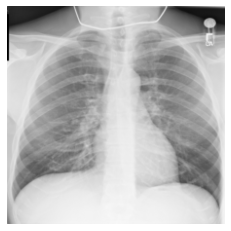

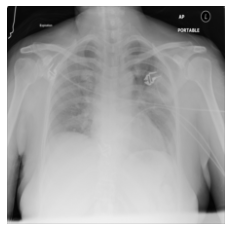

In [45]:
# Class Normal best and worst classified images
best_1 = np.array(class1_image[class1_best])
show_img(best_1[0,])

worst_1 = np.array(class1_image[class1_worst])
show_img(worst_1[0,])

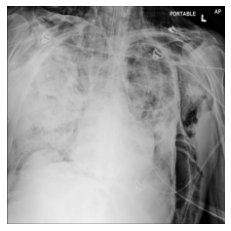

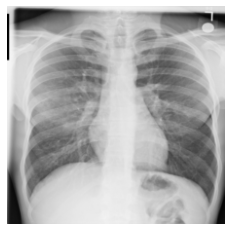

In [46]:
# Class Infected best and worst classified images
best_0 = np.array(class0_image[class0_best])
show_img(best_0[0,])

worst_0 = np.array(class0_image[class0_worst])
show_img(worst_0[0,])